In [1]:
import tensorflow as tf
from utils.modelLoader import ModelLoader
import pandas as pd
from utils.utilities import buildRunName
import numpy as np


In [2]:
@tf.function
def decode_img(img_path):
    image_size = (224, 224)
    num_channels = 3
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(
        img, channels=num_channels, expand_animations=False
    )
    img = tf.image.resize(img, image_size, method="bilinear")
    img.set_shape((image_size[0], image_size[1], num_channels))
    return img

def process_path(file_path, labels):
    label = {'out_age_prediction': tf.reshape(tf.keras.backend.cast(labels[0], tf.keras.backend.floatx()), (1, 1)),
             'out_face_detection': tf.reshape(tf.keras.backend.cast(labels[1], tf.keras.backend.floatx()), (1, 1)),
             'out_mask_detection': tf.reshape(tf.keras.backend.cast(labels[2], tf.keras.backend.floatx()), (1, 1))}
    img = decode_img(file_path)
    return img, label

def group_ages(age: int):
    current_range = [
        ( 0, 0),
        ( 1,10),
        (11,20),
        (21,30),
        (31,40),
        (41,50),
        (51,60),
        (61,70),
        (71,80),
        (81,90),
        (91,100)
    ]
    if isinstance(age, int) and age >= current_range[0] and age <= current_range[1]:
        return current_range.index(current_range)
    else:
        return age

def create_dataset(data):
    data = tf.data.Dataset.from_tensor_slices(
        (data["Filepath"], data[["Age", "Face", "Mask"]]))
    ds = data.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(32)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds


metaData = pd.read_json("../data_meta/meta_all.json")
metaData = metaData.sample(frac=1, random_state=123).reset_index(drop=True)
metaData_train = metaData.iloc[0:int(metaData.__len__() * 0.7)]
metaData_val =  metaData.iloc[int(metaData.__len__() * 0.7)+1:int(metaData.__len__() * 0.85)]
metaData_test = metaData.iloc[int(metaData.__len__() * 0.85)+1:]

train_ds = create_dataset(metaData_train)
val_ds = create_dataset(metaData_val)
test_ds = create_dataset(metaData_test)

model = ModelLoader().loadMobileNetV1Multi(10, ageDropout=0.2)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss={
        "out_age_prediction": tf.keras.losses.SparseCategoricalCrossentropy(ignore_class=-1),
        "out_face_detection": tf.keras.losses.BinaryCrossentropy(),
        "out_mask_detection": tf.keras.losses.BinaryCrossentropy(),
    },
    loss_weights={
        "out_age_prediction": 0.33,
        "out_face_detection": 0.33,
        "out_mask_detection": 0.33,
    },
    metrics={
        "out_age_prediction": tf.keras.metrics.SparseCategoricalAccuracy(),
        "out_face_detection": tf.keras.metrics.BinaryAccuracy(),
        "out_mask_detection": tf.keras.metrics.BinaryAccuracy(),
    },
)


log_dir = "../logs/fit/" + buildRunName("MobileNet_MultiTask", 200, 32)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    callbacks=[tensorboard_callback]
)

model.save("../models/" + buildRunName("MobileNet_MultiTask", 200, 32))

Epoch 1/200
866/866 [==============================] - 131s 141ms/step - loss: 0.5337 - out_face_detection_loss: 0.0355 - out_mask_detection_loss: 0.0303 - out_age_prediction_loss: 1.5514 - out_face_detection_binary_accuracy: 0.9900 - out_mask_detection_binary_accuracy: 0.9899 - out_age_prediction_sparse_categorical_accuracy: 0.2227 - val_loss: 0.4626 - val_out_face_detection_loss: 0.0062 - val_out_mask_detection_loss: 0.0192 - val_out_age_prediction_loss: 1.3765 - val_out_face_detection_binary_accuracy: 0.9990 - val_out_mask_detection_binary_accuracy: 0.9944 - val_out_age_prediction_sparse_categorical_accuracy: 0.2669
Epoch 2/200
866/866 [==============================] - 49s 57ms/step - loss: 0.4610 - out_face_detection_loss: 0.0064 - out_mask_detection_loss: 0.0120 - out_age_prediction_loss: 1.3787 - out_face_detection_binary_accuracy: 0.9985 - out_mask_detection_binary_accuracy: 0.9962 - out_age_prediction_sparse_categorical_accuracy: 0.2499 - val_loss: 0.4429 - val_out_face_detect

INFO:tensorflow:Assets written to: ../models/MobileNet_MultiTask_epochs-200_batch-32\assets


INFO:tensorflow:Assets written to: ../models/MobileNet_MultiTask_epochs-200_batch-32\assets


In [10]:
model.evaluate(test_ds)

In [8]:
metaData_age = pd.read_json("../data_meta/meta_all_onlyAge.json")
metaData_age = metaData_age.sample(frac=1, random_state=123).reset_index(drop=True)

test_age_ds = create_dataset(metaData_age)

In [9]:
model.evaluate(test_age_ds)

672/672 [==============================] - 35s 52ms/step - loss: 0.4758 - out_face_detection_loss: 0.0017 - out_mask_detection_loss: 0.0013 - out_age_prediction_loss: 1.4389 - out_face_detection_binary_accuracy: 0.9996 - out_mask_detection_binary_accuracy: 0.9997 - out_age_prediction_sparse_categorical_accuracy: 0.6577


[0.475816935300827,
 0.0016594651388004422,
 0.0013235326623544097,
 1.438886284828186,
 0.9995808601379395,
 0.9996740221977234,
 0.657663106918335]

In [2]:
model = tf.keras.models.load_model("../models/MobileNet_MultiTask_epochs-50_batch-32/")

In [16]:
image = tf.io.read_file("../doc/images/Mask_white.png")
image = tf.image.decode_image(image, channels=3)
image = np.expand_dims(image.numpy(), axis=0)
image = tf.image.resize(image, (224,224))
res = model.predict(image)

1/1 [==============================] - 0s 26ms/step


In [17]:
res

[array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[3.4659162e-01, 6.5340835e-01, 3.4264069e-10, 3.5887388e-15,
         1.2848406e-11, 6.2063493e-14, 3.2212595e-15, 8.8247953e-16,
         2.6256503e-13, 1.6227032e-35]], dtype=float32)]

In [18]:
np.argmax(res[2])

1

In [ ]:
metaDataAge = pd.read_json("../data_meta/meta_all_onlyAge.json")

actVals = list()
predVals = list()

for index, imageMataData in metaDataAge.iterrows():
    image = tf.io.read_file(imageMataData["Filepath"])
    image = tf.image.decode_image(image, channels=3)
    image = np.expand_dims(image.numpy(), axis=0)
    image = tf.image.resize(image, (224,224))
    _,_,predAge = model.predict(image)
    predVals.append(np.argmax(predAge))
    actVals.append(imageMataData["Age"])

In [15]:
predValsTemp = [int(x) for x in actVals]

import json
file = open("tempdump2.json", "w")
temp = json.dumps(predValsTemp)
file.write(temp)
file.close()

In [6]:
import json
file = open("tempdump1.json", "r")
temp = json.load(file)
file.close()

In [7]:
predVals = temp

In [5]:
actVals = temp

In [8]:
from sklearn import metrics
accuracy = metrics.accuracy_score(actVals, predVals)
accuracy

0.6555674568062217

Text(0.5, 1.0, 'Age Distribution in Dataset')

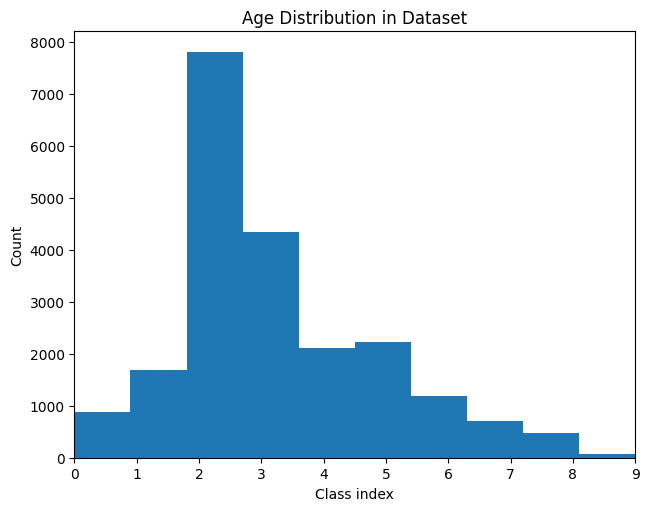

In [19]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

ax.hist(actVals)
ax.set_xlim([0, 9])
plt.tight_layout()
ax.set_xticks(ticks=[0,1,2,3,4,5,6,7,8,9], label=["1-10", "11-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80", "81-90", "91-100"])
ax.set_xlabel("Class index")
ax.set_ylabel("Count")
ax.set_title("Age Distribution in Dataset")

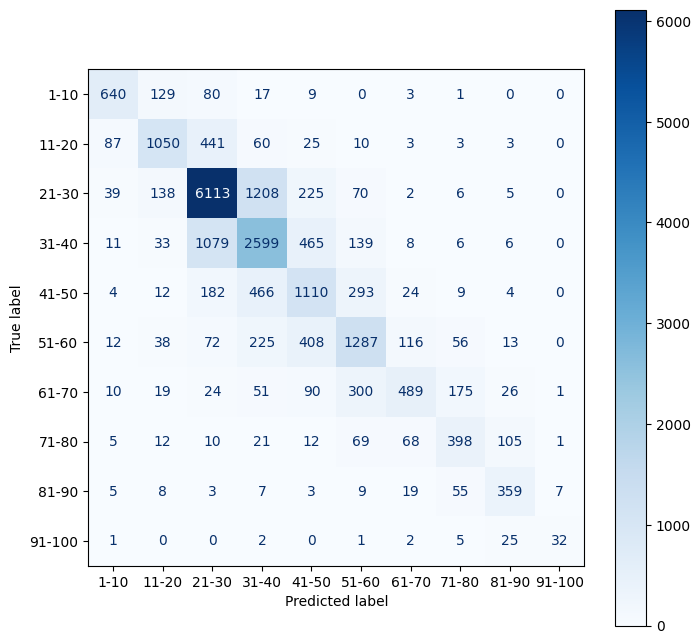

In [26]:
from sklearn import metrics
import matplotlib as plt

confusion_matrix = metrics.confusion_matrix(actVals, predVals)


cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["1-10", "11-20", "21-30", "31-40", "41-50", "51-60", "61-70", "71-80", "81-90", "91-100"])
cm_display.plot(cmap="Blues")
cm_display.figure_.set_size_inches([8, 8])